<a href="https://colab.research.google.com/github/jackie-Gung/Colab_ESAA/blob/main/2022_12_05_%EC%84%B8%EC%85%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **1. 라이브러리**

In [3]:
import numpy as np
import pandas as pd 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

In [5]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

### **2. 데이터 확인하기**

#### **1) 데이터 불러오기**

In [6]:
filenames = os.listdir("/content/drive/MyDrive/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [7]:
df.head()

,filename,category
0,dog.46.jpg,1
1,dog.461.jpg,1
2,dog.466.jpg,1
3,dog.462.jpg,1
4,dog.464.jpg,1


#### **2) See total in count**

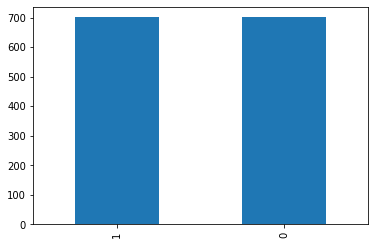

In [8]:
df['category'].value_counts().plot.bar()

#### **3) sample images**

### **3. Build Model**

In [11]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 61, 61, 64)       2

In [12]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [13]:
earlystop = EarlyStopping(patience=10)

In [14]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=2, verbose=1, factor=0.5, min_lr=0.00001)

In [15]:
callbacks = [earlystop, learning_rate_reduction]

### **4. Prepare data**

In [16]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 

In [17]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

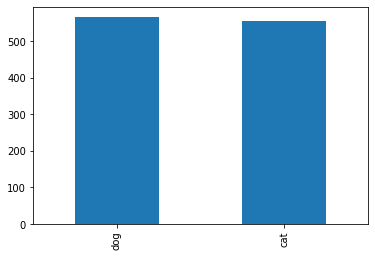

In [18]:
train_df['category'].value_counts().plot.bar()

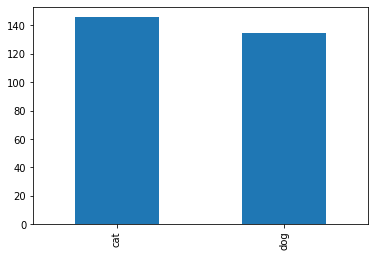

In [19]:
validate_df['category'].value_counts().plot.bar()

In [20]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

### **5. Training Generator**

In [21]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "/content/drive/MyDrive/train", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 1121 validated image filenames belonging to 2 classes.


In [22]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "/content/drive/MyDrive/train", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 281 validated image filenames belonging to 2 classes.


### **6. See how generator works**

In [23]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "/content/drive/MyDrive/train", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


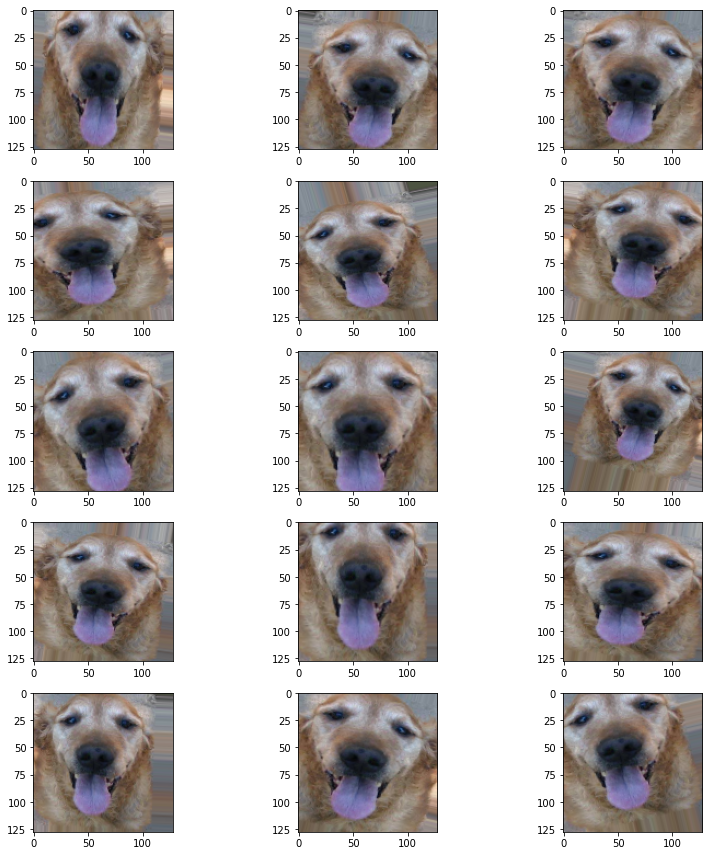

In [24]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

### **7. Fit Model**

In [25]:
epochs=3 if FAST_RUN else 50
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

<ipython-input-25-63cb34b6e89a>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/50
74/74 [==============================] - ETA: 0s - loss: 1.4075 - accuracy: 0.5316

74/74 [==============================] - 693s 9s/step - loss: 1.4075 - accuracy: 0.5316 - val_loss: 0.7316 - val_accuracy: 0.5519 - lr: 0.0010
Epoch 2/50
74/74 [==============================] - ETA: 0s - loss: 1.0844 - accuracy: 0.5687

74/74 [==============================] - 68s 912ms/step - loss: 1.0844 - accuracy: 0.5687 - val_loss: 1.1775 - val_accuracy: 0.5222 - lr: 0.0010
Epoch 3/50
74/74 [==============================] - ETA: 0s - loss: 0.8904 - accuracy: 0.5886

74/74 [==============================] - 66s 886ms/step - loss: 0.8904 - accuracy: 0.5886 - val_loss: 1.6693 - val_accuracy: 0.5333 - lr: 0.0010
Epoch 4/50
74/74 [==============================] - ETA: 0s - loss: 0.8346 - accuracy: 0.5949

74/74 [==============================] - 65s 882ms/step - loss: 0.8346 - accuracy: 0.5949 - val_loss: 1.3735 - val_accuracy: 0.5148 - lr: 0.0010
Epoch 5/50
74/74 [==============================] - ETA: 0s - loss: 0.7520 - accuracy: 0.6112

74/74 [==============================] - 67s 908ms/step - loss: 0.7520 - accuracy: 0.6112 - val_loss: 1.0723 - val_accuracy: 0.5185 - lr: 0.0010
Epoch 6/50
74/74 [==============================] - ETA: 0s - loss: 0.6957 - accuracy: 0.6510

74/74 [==============================] - 65s 880ms/step - loss: 0.6957 - accuracy: 0.6510 - val_loss: 0.7471 - val_accuracy: 0.5704 - lr: 0.0010
Epoch 7/50
74/74 [==============================] - ETA: 0s - loss: 0.6770 - accuracy: 0.6293

74/74 [==============================] - 65s 882ms/step - loss: 0.6770 - accuracy: 0.6293 - val_loss: 0.6479 - val_accuracy: 0.6370 - lr: 0.0010
Epoch 8/50
74/74 [==============================] - ETA: 0s - loss: 0.6240 - accuracy: 0.6772

74/74 [==============================] - 65s 875ms/step - loss: 0.6240 - accuracy: 0.6772 - val_loss: 0.6479 - val_accuracy: 0.6407 - lr: 0.0010
Epoch 9/50
74/74 [==============================] - ETA: 0s - loss: 0.6047 - accuracy: 0.6917

74/74 [==============================] - 67s 895ms/step - loss: 0.6047 - accuracy: 0.6917 - val_loss: 0.5457 - val_accuracy: 0.7000 - lr: 0.0010
Epoch 10/50
74/74 [==============================] - ETA: 0s - loss: 0.6136 - accuracy: 0.7043

74/74 [==============================] - 65s 881ms/step - loss: 0.6136 - accuracy: 0.7043 - val_loss: 0.5571 - val_accuracy: 0.7185 - lr: 0.0010
Epoch 11/50
74/74 [==============================] - ETA: 0s - loss: 0.5796 - accuracy: 0.7134

74/74 [==============================] - 66s 894ms/step - loss: 0.5796 - accuracy: 0.7134 - val_loss: 0.6177 - val_accuracy: 0.6963 - lr: 0.0010
Epoch 12/50
74/74 [==============================] - ETA: 0s - loss: 0.5547 - accuracy: 0.7288

74/74 [==============================] - 68s 914ms/step - loss: 0.5547 - accuracy: 0.7288 - val_loss: 0.5955 - val_accuracy: 0.6778 - lr: 0.0010
Epoch 13/50
74/74 [==============================] - ETA: 0s - loss: 0.5641 - accuracy: 0.7224

74/74 [==============================] - 66s 891ms/step - loss: 0.5641 - accuracy: 0.7224 - val_loss: 0.6897 - val_accuracy: 0.6741 - lr: 0.0010
Epoch 14/50
74/74 [==============================] - ETA: 0s - loss: 0.5334 - accuracy: 0.7559

74/74 [==============================] - 66s 884ms/step - loss: 0.5334 - accuracy: 0.7559 - val_loss: 0.7929 - val_accuracy: 0.6296 - lr: 0.0010
Epoch 15/50
74/74 [==============================] - ETA: 0s - loss: 0.5490 - accuracy: 0.7324

74/74 [==============================] - 67s 907ms/step - loss: 0.5490 - accuracy: 0.7324 - val_loss: 0.5603 - val_accuracy: 0.7333 - lr: 0.0010
Epoch 16/50
74/74 [==============================] - ETA: 0s - loss: 0.5570 - accuracy: 0.7242

74/74 [==============================] - 65s 878ms/step - loss: 0.5570 - accuracy: 0.7242 - val_loss: 0.8245 - val_accuracy: 0.6556 - lr: 0.0010
Epoch 17/50
74/74 [==============================] - ETA: 0s - loss: 0.5329 - accuracy: 0.7441

74/74 [==============================] - 65s 878ms/step - loss: 0.5329 - accuracy: 0.7441 - val_loss: 0.4997 - val_accuracy: 0.7593 - lr: 0.0010
Epoch 18/50
74/74 [==============================] - ETA: 0s - loss: 0.5326 - accuracy: 0.7360

74/74 [==============================] - 67s 910ms/step - loss: 0.5326 - accuracy: 0.7360 - val_loss: 0.4928 - val_accuracy: 0.7667 - lr: 0.0010
Epoch 19/50
74/74 [==============================] - ETA: 0s - loss: 0.4838 - accuracy: 0.7604

74/74 [==============================] - 65s 871ms/step - loss: 0.4838 - accuracy: 0.7604 - val_loss: 0.5148 - val_accuracy: 0.7630 - lr: 0.0010
Epoch 20/50
74/74 [==============================] - ETA: 0s - loss: 0.5165 - accuracy: 0.7441

74/74 [==============================] - 64s 869ms/step - loss: 0.5165 - accuracy: 0.7441 - val_loss: 0.6109 - val_accuracy: 0.7074 - lr: 0.0010
Epoch 21/50
74/74 [==============================] - ETA: 0s - loss: 0.4839 - accuracy: 0.7622

74/74 [==============================] - 66s 884ms/step - loss: 0.4839 - accuracy: 0.7622 - val_loss: 0.5321 - val_accuracy: 0.7444 - lr: 0.0010
Epoch 22/50
74/74 [==============================] - ETA: 0s - loss: 0.4719 - accuracy: 0.7785

74/74 [==============================] - 69s 932ms/step - loss: 0.4719 - accuracy: 0.7785 - val_loss: 0.5400 - val_accuracy: 0.7407 - lr: 0.0010
Epoch 23/50
74/74 [==============================] - ETA: 0s - loss: 0.4792 - accuracy: 0.7776

74/74 [==============================] - 66s 885ms/step - loss: 0.4792 - accuracy: 0.7776 - val_loss: 0.5519 - val_accuracy: 0.7444 - lr: 0.0010
Epoch 24/50
74/74 [==============================] - ETA: 0s - loss: 0.4692 - accuracy: 0.7731

74/74 [==============================] - 65s 877ms/step - loss: 0.4692 - accuracy: 0.7731 - val_loss: 0.5639 - val_accuracy: 0.7259 - lr: 0.0010
Epoch 25/50
74/74 [==============================] - ETA: 0s - loss: 0.4578 - accuracy: 0.7758

74/74 [==============================] - 66s 882ms/step - loss: 0.4578 - accuracy: 0.7758 - val_loss: 0.5299 - val_accuracy: 0.7741 - lr: 0.0010
Epoch 26/50
74/74 [==============================] - ETA: 0s - loss: 0.4752 - accuracy: 0.7803

74/74 [==============================] - 65s 878ms/step - loss: 0.4752 - accuracy: 0.7803 - val_loss: 0.5650 - val_accuracy: 0.7333 - lr: 0.0010
Epoch 27/50
74/74 [==============================] - ETA: 0s - loss: 0.4588 - accuracy: 0.7984

74/74 [==============================] - 66s 887ms/step - loss: 0.4588 - accuracy: 0.7984 - val_loss: 0.4454 - val_accuracy: 0.8111 - lr: 0.0010
Epoch 28/50
74/74 [==============================] - ETA: 0s - loss: 0.4398 - accuracy: 0.8029

74/74 [==============================] - 68s 909ms/step - loss: 0.4398 - accuracy: 0.8029 - val_loss: 0.7619 - val_accuracy: 0.6852 - lr: 0.0010
Epoch 29/50
74/74 [==============================] - ETA: 0s - loss: 0.4393 - accuracy: 0.8092

74/74 [==============================] - 66s 885ms/step - loss: 0.4393 - accuracy: 0.8092 - val_loss: 0.5458 - val_accuracy: 0.7370 - lr: 0.0010
Epoch 30/50
74/74 [==============================] - ETA: 0s - loss: 0.4513 - accuracy: 0.8047

74/74 [==============================] - 65s 882ms/step - loss: 0.4513 - accuracy: 0.8047 - val_loss: 0.4964 - val_accuracy: 0.7741 - lr: 0.0010
Epoch 31/50
74/74 [==============================] - ETA: 0s - loss: 0.4683 - accuracy: 0.7902

74/74 [==============================] - 67s 910ms/step - loss: 0.4683 - accuracy: 0.7902 - val_loss: 0.4695 - val_accuracy: 0.7704 - lr: 0.0010
Epoch 32/50
74/74 [==============================] - ETA: 0s - loss: 0.4312 - accuracy: 0.8056

74/74 [==============================] - 66s 888ms/step - loss: 0.4312 - accuracy: 0.8056 - val_loss: 0.6019 - val_accuracy: 0.7333 - lr: 0.0010
Epoch 33/50
74/74 [==============================] - ETA: 0s - loss: 0.4209 - accuracy: 0.8065

74/74 [==============================] - 66s 888ms/step - loss: 0.4209 - accuracy: 0.8065 - val_loss: 0.5788 - val_accuracy: 0.7556 - lr: 0.0010
Epoch 34/50
74/74 [==============================] - ETA: 0s - loss: 0.4346 - accuracy: 0.7939

74/74 [==============================] - 67s 910ms/step - loss: 0.4346 - accuracy: 0.7939 - val_loss: 0.5133 - val_accuracy: 0.7556 - lr: 0.0010
Epoch 35/50
74/74 [==============================] - ETA: 0s - loss: 0.4399 - accuracy: 0.8081

74/74 [==============================] - 66s 885ms/step - loss: 0.4399 - accuracy: 0.8081 - val_loss: 0.5261 - val_accuracy: 0.7667 - lr: 0.0010
Epoch 36/50
74/74 [==============================] - ETA: 0s - loss: 0.4174 - accuracy: 0.8083

74/74 [==============================] - 65s 876ms/step - loss: 0.4174 - accuracy: 0.8083 - val_loss: 0.7270 - val_accuracy: 0.7148 - lr: 0.0010
Epoch 37/50
74/74 [==============================] - ETA: 0s - loss: 0.3971 - accuracy: 0.8228

74/74 [==============================] - 65s 881ms/step - loss: 0.3971 - accuracy: 0.8228 - val_loss: 0.7941 - val_accuracy: 0.6852 - lr: 0.0010


In [26]:
# save model
model.save_weights("model.h5")

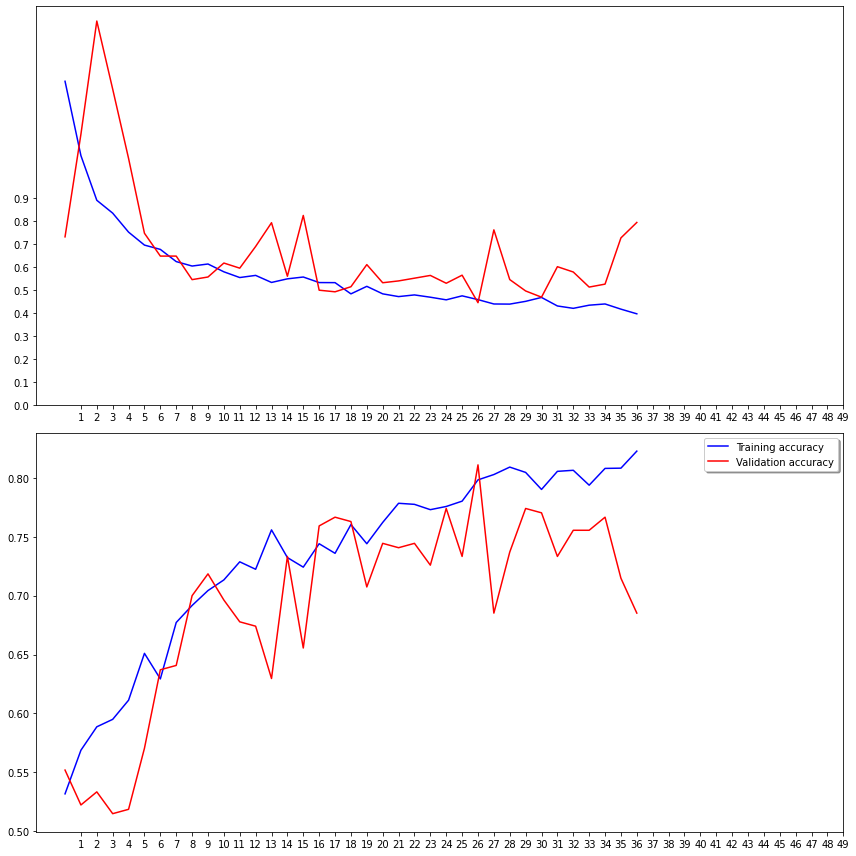

In [27]:
# virtualize
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

### **8. Prepare Test data**

In [28]:
test_filenames = os.listdir("/content/drive/MyDrive/test")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [29]:
# create generator
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "/content/drive/MyDrive/test", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 500 validated image filenames.


In [30]:
# predict
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

<ipython-input-30-c78fb2cae804>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))


In [31]:
test_df['category'] = np.argmax(predict, axis=-1)

In [32]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

In [33]:
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

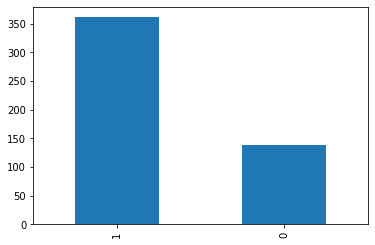

In [34]:
test_df['category'].value_counts().plot.bar()

In [35]:
# submission
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv('submission.csv', index=False)